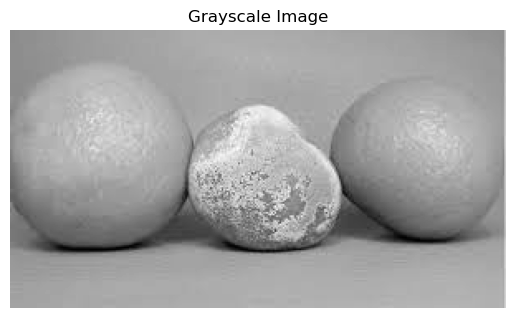

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load image
image = cv2.imread(r'C:\Users\Acer\OneDrive\Documents\final\test\test16.png')

# Convert image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Show grayscale image
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()


In [2]:
import cv2
import numpy as np
from ultralytics import YOLO

def analyze_and_correct_detections(image, detections, categories):
    """
    Analyze detections and apply corrections if needed
    """
    corrected_detections = []
    
    for box in detections.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])
        confidence = float(box.conf[0])
        
        # Extract the fruit region for additional verification
        fruit_region = image[y1:y2, x1:x2]
        
        # Calculate color statistics (BGR format)
        avg_color = np.mean(fruit_region, axis=(0, 1))
        blue, green, red = avg_color
        
        # Apply correction rules based on color analysis
        # Healthy fruits typically have more green/red than rotten ones
        if class_id == 1:  # If classified as rotten
            # Rule 1: High green component might indicate healthy fruit
            if green > 100 and red > 100 and blue < 100:
                print(f"Potential misclassification detected (high green/red) at ({x1},{y1})-({x2},{y2})")
                print(f"Original: Rotten, Color analysis: B:{blue:.1f}, G:{green:.1f}, R:{red:.1f}")
                # Reclassify as healthy if color suggests so
                class_id = 0
                confidence = min(confidence + 0.1, 1.0)  # Boost confidence slightly
        
        corrected_detections.append((x1, y1, x2, y2, class_id, confidence))
    
    return corrected_detections

def calculate_rotten_percentage(fruit_region):
    """
    Calculate the percentage of the rotten area in the given fruit region
    """
    # Convert the fruit region to grayscale
    gray_fruit = cv2.cvtColor(fruit_region, cv2.COLOR_BGR2GRAY)

    # Apply a simple threshold to isolate the rotten part (assuming it appears darker)
    _, binary_mask = cv2.threshold(gray_fruit, 100, 255, cv2.THRESH_BINARY_INV)

    # Calculate the area of the rotten part
    rotten_area = np.sum(binary_mask == 255)
    
    # Calculate the total area of the fruit
    total_area = fruit_region.size / 3  # Each pixel has 3 channels (BGR)

    # Calculate the percentage of rotten area
    rotten_percentage = (rotten_area / total_area) * 100
    
    return rotten_percentage, binary_mask

def highlight_rotten_area(image, x1, y1, x2, y2, binary_mask):
    """
    Highlight the rotten area in the image by overlaying the binary mask
    """
    # Overlay the binary mask on the original image
    highlighted_image = image.copy()

    # Apply the mask in red (BGR format)
    highlighted_image[y1:y2, x1:x2][binary_mask == 255] = [192, 192, 192]  # Silver color in BGR

    return highlighted_image

def test_yolo_fruit_classification(yolo_model_path, image_path, conf_threshold=0.5):
    # Load YOLO model
    model = YOLO(yolo_model_path)
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
    
    # Run inference with confidence threshold
    results = model(image, conf=conf_threshold, iou=0.45)[0]
    
    # Class names
    categories = ["Healthy", "Rotten"]
    
    # Analyze and potentially correct detections
    corrected_dets = analyze_and_correct_detections(image, results, categories)
    
    # List to store rotten percentages
    rotten_percentages = []
    
    # Visualize results
    for det in corrected_dets:
        x1, y1, x2, y2, class_id, confidence = det
        label = f"{categories[class_id]} ({confidence:.2f})"
        color = (0, 255, 0) if class_id == 0 else (0, 0, 255)  # Green for Healthy, Red for Rotten
        
        # Extract the fruit region for rotten percentage calculation
        fruit_region = image[y1:y2, x1:x2]
        
        if class_id == 1:  # If the fruit is rotten
            # Calculate the rotten percentage
            rotten_percentage, binary_mask = calculate_rotten_percentage(fruit_region)
            rotten_percentages.append(rotten_percentage)
            print(f"Rotten percentage for fruit at ({x1},{y1})-({x2},{y2}): {rotten_percentage:.2f}%")
            
            # Highlight the rotten area
            image = highlight_rotten_area(image, x1, y1, x2, y2, binary_mask)
        
        # Draw box and label
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Display result
    cv2.imshow("YOLO Fruit Detection with Rotten Highlighting", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Save the result
    output_path = image_path.replace(".png", "_highlighted.png")
    cv2.imwrite(output_path, image)
    print(f"Result saved to {output_path}")

    # Return the rotten percentages for all detected fruits
    return rotten_percentages

if __name__ == "__main__":
    yolo_weights = r"C:\Users\Acer\OneDrive\Documents\final\runs\detect\train\weights\best.pt"
    test_image = r"C:\Users\Acer\OneDrive\Documents\final\test\test1.png"
    
    # Try different confidence thresholds between 0.4-0.7
    rotten_percentages = test_yolo_fruit_classification(yolo_weights, test_image, conf_threshold=0.5)
    
    # Print all rotten percentages
    for i, percentage in enumerate(rotten_percentages):
        print(f"Fruit {i+1} Rotten Percentage: {percentage:.2f}%")



0: 448x640 (no detections), 310.3ms
Speed: 7.8ms preprocess, 310.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)
Result saved to C:\Users\Acer\OneDrive\Documents\final\test\test1_highlighted.png
